# Demo for Pixel Deflection - a simple transformation based defense

## Change local pixel arrangement and then denoise using wavelet transform

Paper: https://arxiv.org/abs/1801.08926

Code : https://github.com/iamaaditya/pixel-deflection

This Jupyter Notebook: https://github.com/iamaaditya/pixel-deflection/blob/master/demo.ipynb

**What**

1. Select a random pixel and replace it with another randomly selected pixel from a local neighborhood; we call this pixel deflection (PD).

2. Use a class-activation type map (R-CAM) to select the pixel to deflect. The less important the pixel for classification, the higher the chances that it will get deflected.

3. Do a soft shrinkage over the wavelet domain to remove the added noise (WD).

**Why**

1. PD changes local statistics without affecting global statistics. Adversarial examples rely on specific activations; PD changes that but not enough to change the overall image category.

2. Most attacks are agnostic to presence of semantic objects in the image; by picking more pixels outside the regions-of-interest we increase the likelihood of destroying the adversarial pertubation but not much of the content.

3. Classifiers are trained on images without such (PD) noise. We can smooth the impact of such noise by denoising, for which we found that BayesShrink on DWT works best.

## Load the requirements

In [160]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint, uniform

### Load the classifier
Classifier can be easily changed to inception_v3, vgg19, xception, etc. [see this](https://github.com/iamaaditya/pixel-deflection/blob/master/main.py#L65)

In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')

In [145]:
def load_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img)
    true_label = img_path.split('/')[-1].split('_')[0]
    return img, true_label

In [153]:
def visualize_classification(class_names, probs, image, true_class=-1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.sca(ax1)
    
    ax1.imshow(image.astype('uint8'))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Image')
    
    y_pos = np.arange(len(class_names))
    barlist = ax2.bar(y_pos, probs, align='center', alpha=0.5)
    if true_class >= 0 and true_class <= 4:
        barlist[true_class].set_color('g')
    ax2.set_xticks(y_pos, minor=False)
    ax2.set_xticklabels(class_names, minor=False, rotation='vertical')
    ax2.set_ylabel('Probability of given class')
    ax2.set_title('Classification')
   
    for bar in barlist:
        v = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., 1.02*v, '%.2f' % v, ha='center')

This classification function works for multiple images in a batch. However, visualization is limited to the first image in the batch.
See our GitHub code for better batch processing functions.

In [200]:
def classify_images(images_arr, true_label, visualize=False):
    images = preprocess_input(np.stack(images_arr,axis=0))
    predictions = decode_predictions(model.predict(images),top=5)
    labels, class_names, probs = [], [], []
    for p in predictions:
        labels.append([i[0] for i in p])
        class_names.append([i[1] for i in p])
        probs.append([i[2] for i in p])
    
    if visualize:
        label_index = labels[0].index(true_label) if true_label in labels[0] else -1
        visualize_classification(class_names[0], probs[0], images_arr[0], label_index)
    
    return labels, class_names, probs

## Load and classify the original

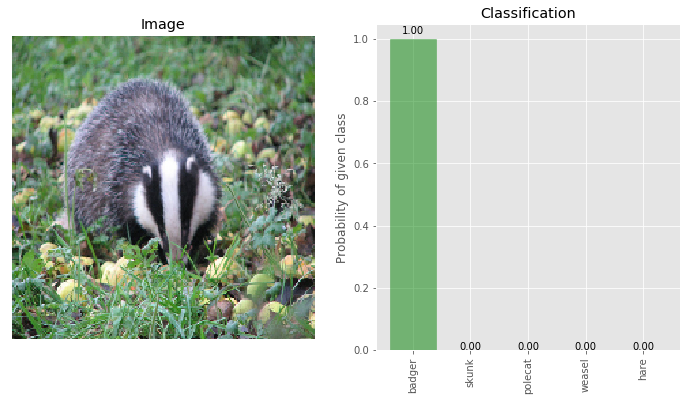

In [291]:
img_clean, true_label = load_image('originals/n02447366_00008562.png')
_ = classify_images([img_clean], true_label, visualize=True)

Green color bar indicates the 'true' class of the image. 
The image is correctly classified as **'badger'** with 100% confidence.

## Load and classify the adversarial image

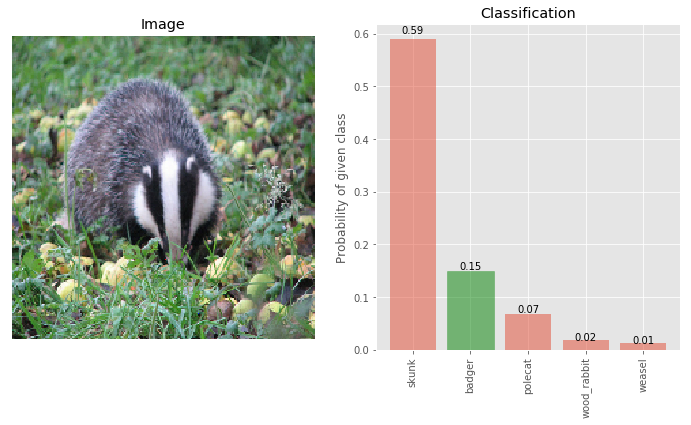

In [292]:
img_adversary, true_label = load_image('images/n02447366_00008562.png')
_ = classify_images([img_adversary], true_label, visualize=True)

The true class **'badger'** is now only 15% and __'skunk'__ is the most likely class with 59% classification.
This adversary was obtained using IGSM attack model. [See this](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks.py#L321) for the attack code.

# Pixel Deflection

In our paper, we use pixel deflection with an activation map, but first let's look at pixel deflection without any maps.

In [282]:
def pixel_deflection_without_map(img, deflections, window):
    img = np.copy(img)
    H, W, C = img.shape
    while deflections > 0:
        #for consistency, when we deflect the given pixel from all the three channels.
        for c in range(C):
            x,y = randint(0,H-1), randint(0,W-1)
            while True: #this is to ensure that PD pixel lies inside the image
                a,b = randint(-1*window,window), randint(-1*window,window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            # calling pixel deflection as pixel swap would be a misnomer,
            # as we can see below, it is one way copy
            img[x,y,c] = img[x+a,y+b,c] 
        deflections -= 1
    return img

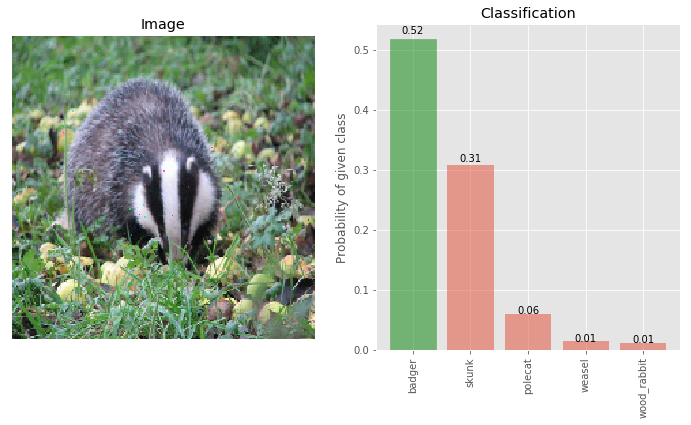

In [416]:
# pixel deflection on adversarial image
img_deflected = pixel_deflection_without_map(img_adversary, deflections=200, window=10)
_ = classify_images([img_deflected], true_label, visualize=True)

Pixel Deflection is able to retrieve the original class of the image, although the confidence of the true class **badger** has gone down significantly when compared with the clean image -  from 99.7% to 52%.

### Let's see the pixels that were deflected.

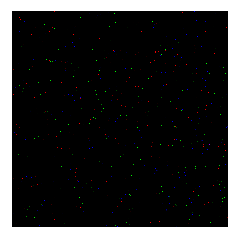

In [299]:
# deflected pixels
diff = img_adversary - img_deflected
plt.imshow(diff.astype('uint8'))
_=plt.xticks([]), plt.yticks([])


Since we are not using any map, the probability of selecting any pixel in the image is equally likely.
If deflecting 200 pixels can cause such a big change in the class probabilities (**skunk** from 59% from 25% and **badger** from 15% to 54%), then it begs the question, how much impact will this transformation (pixel deflection) have on the clean images?


## Impact on the clean image

For most transformation-based defenses impact on the clean image is too severe, which makes them less useful (e.g. JPEG, TVM)
However, the impact of Pixel Deflection on the clean image is almost negligible.

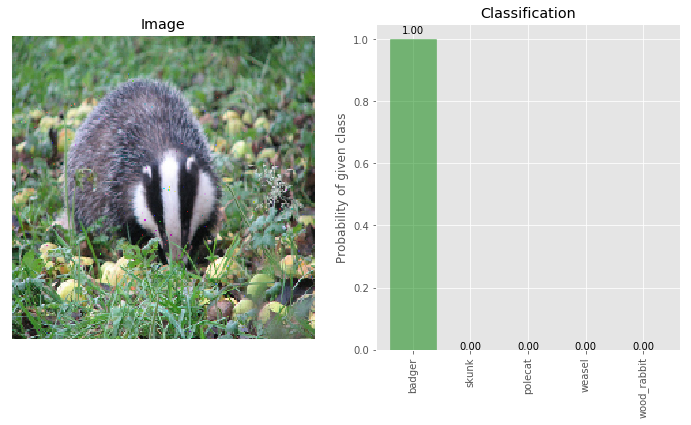

In [412]:
# deflections on clean image
img_clean_deflected = pixel_deflection_without_map(img_clean, deflections=200, window=10)
_ = classify_images([img_clean_deflected], true_label, visualize=True)

Probability of the true class being **badger** remains at 100%. 
Let's investigate the diff with the clean image.

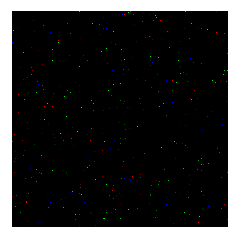

In [301]:
diff = img_clean - img_clean_deflected
plt.imshow(diff.astype('uint8'))
_=plt.xticks([]), plt.yticks([])

## Impact of increasing number of deflections
Increasing the number of deflections significantly increases the accruacy of the recovery of the true class.

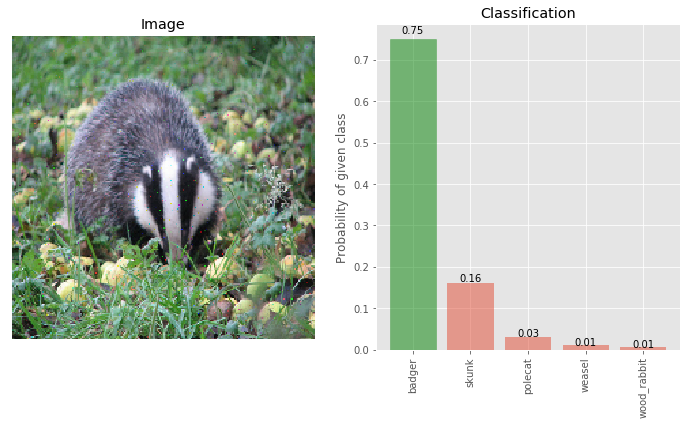

In [411]:
# More deflections on adversarial image
img_deflected_more = pixel_deflection_without_map(img_adversary, deflections=600, window=10)
_ = classify_images([img_deflected_more], true_label, visualize=True)

Now the accuracy jumps to 75% but it does not change degrade the accuracy on clean image, as shown below.


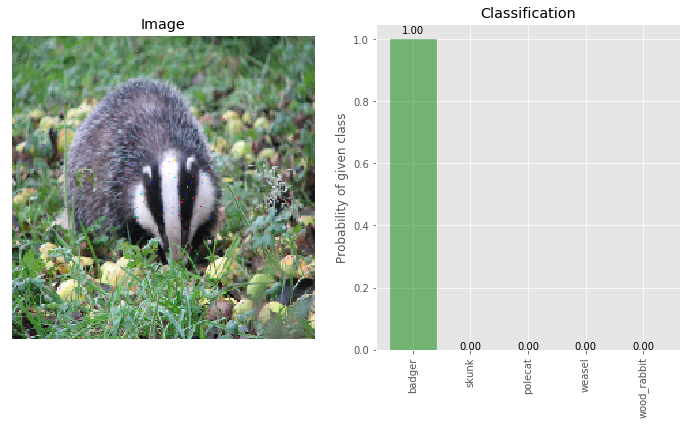

In [410]:
# More deflections on clean image
img_clean_deflected_more = pixel_deflection_without_map(img_clean, deflections=600, window=10)
_ = classify_images([img_clean_deflected_more], true_label, visualize=True)

## Results so far

| Class         | Clean         | Adversary  | Pixel Deflection  |
| ------------- |:-------------:| -----     :| -----   :|
| True class - Badger | $100$ | $15$ | $75$
| Adversary  - Skunk  | $0.0$ | $59$ | $16$

<center> (numbers denote confidence in each class) </center>

# Wavelet Denoiser

As we state in our paper, pixel-deflection is a form of artifical noise and denoising this image will get rid of some of this noise.
Let's see what happens after applying wavelet denoising.

In [286]:
from skimage.restoration import denoise_wavelet
def denoiser(img):
    return denoise_wavelet(img/255.0, sigma=0.04, mode='soft', multichannel=True, convert2ycbcr=True, method='BayesShrink')*255.0

Here we show results only for wavelet denoising, the best of several methods. In our paper, we have reported results for various other forms of denoising. 
To experiment with other types of denoising [see this](https://github.com/iamaaditya/pixel-deflection/blob/master/methods.py#L13)

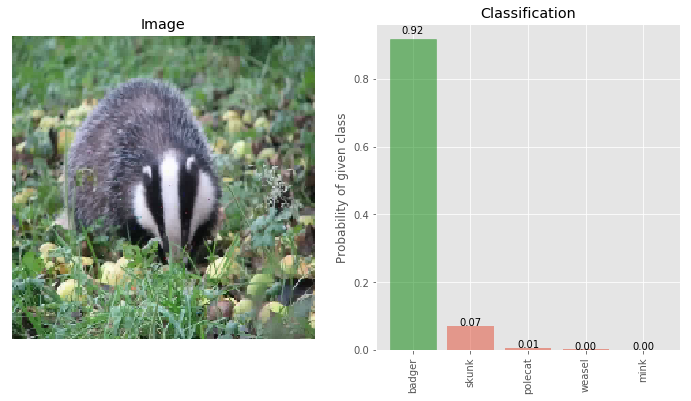

In [287]:
img_deflected_denoised = denoiser(img_deflected)
_ = classify_images([img_deflected_denoised], true_label, visualize=True)

As we can see that the confidence on the true class being **badger** has gone up from 52% to 92% and the adversary class confidence has gone down from 25% to 7%.
Thus, when we combine __Pixel Deflection__ and __Wavlet Denoising__, the overall effect is ----


| Class         | Clean         | Adversary  | PD + WD  |
| ------------- |:-------------:| -----     :| -----   :|
| True class - Badger | 100 | 15 | 92
| Adversary  - Skunk  | 0.0 | 59 | 7

<center> (numbers denote confidence in each class) </center>


## Attacks are non-localized

In our paper we analyzed the location of pixels where the adversary add the perturbation and found out that most attacks are agnostic to the presence of semantic objects. The correlation between pixels of class-object and pixels perturbed by attacks is very low. 
Here is the average location of adversarial perturbation for some of the major known attacks:

![distribution_of_attacks](https://i.imgur.com/ydQ0a5e.png)

The top left image shows the average location of the object (corresponding to the true class of the image). It is no surprise that most objects of interest are in the center of the image. This could just be human bias for taking pictures especially those which are part of ImageNet. 

We take advantage of a non-localized adversary by deflecting more pixels that are outside the regions-of-interest for a given image. Since precise boundaries are not needed, it is sufficient to obtain a weak localization technique like [Class Activation Map](http://cnnlocalization.csail.mit.edu/). However, we found out that CAM has an inherent weakness when it comes to adversarial images.

# CAM vs Robust Activation Maps

Class Activation Maps are heatmaps which highlight the areas most discriminative for a given image and a given class. This works well when the image contains the object given as the class but not so much if the given class name has no presence in the image. In a given adversarial image, by definition, the 'class' of the image is not the same as the true class. Thus, generating CAMs for adversarial images is difficult. 

In order to overcome this, we propose a robust version of CAMs. If we see the Top-5 predictions for the adversarial image ```img_adversary``` other than the 'adversarial class', it is no surprise that most of these classes are closely related to the true class even if not the same; *skunk, polecat, weasel* and *mink* are all similar looking animals. This is a a well known side effect of ImageNet because the thousand classes of ImageNet have lot of fine-grained classes of similar objects/species. 

Robust Activation Map is geometric mean of CAM obtained using the top-K classes. By taking the top-K classes, we average out the impact that a single bad adversarial class may cause to the activation map.

For more details, we refer the reader to [our paper](https://arxiv.org/abs/1801.08926v1).

Here, is a visual comparison of CAM and robust version of CAM.

![cam_vs_rcam](https://i.imgur.com/UV6iKT0.png)


## Apply R-CAM

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


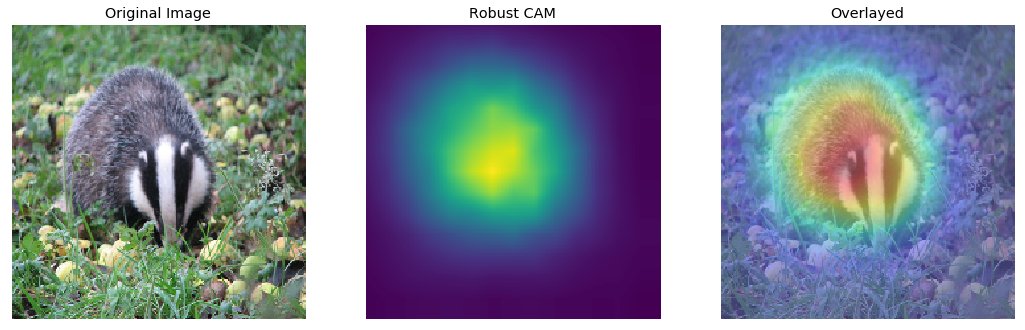

In [422]:
from scipy.misc import imread
from matplotlib.colors import Normalize

# We normalize the map, because rcam_prob is treated
# as probability values
rcam_prob = Normalize()(imread('maps/n02447366_00008562.png'))

f, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].imshow(img_clean.astype('uint8'))
ax[0].set_title('Original Image')
ax[1].imshow(rcam_prob)
ax[1].set_title('Robust CAM')
ax[2].imshow(rcam_prob, cmap='jet', alpha=0.6)
ax[2].imshow(img_clean.astype('uint8'), alpha=0.4)
ax[2].set_title('Overlayed')
for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])


Here is the distribution of the RCAM probabilities:

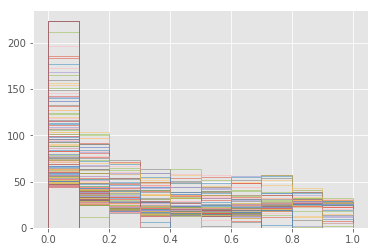

In [378]:
plt.hist(rcam_prob, bins=10, histtype='step')
plt.show()

## Pixel Deflection with R-CAM

In [395]:
def pixel_deflection_with_map(img, rcam_prob, deflections, window):
    img = np.copy(img)
    H, W, C = img.shape
    while deflections > 0:
        #for consistency, when we deflect the given pixel from all the three channels.
        for c in range(C):
            x,y = randint(0,H-1), randint(0,W-1)
            
            # if a uniformly selected value is lower than the rcam probability
            # skip that region
            if uniform(0,1) < rcam_prob[x,y]:
                continue
                
            while True: #this is to ensure that PD pixel lies inside the image
                a,b = randint(-1*window,window), randint(-1*window,window)
                if x+a < H and x+a > 0 and y+b < W and y+b > 0: break
            # calling pixel deflection as pixel swap would be a misnomer,
            # as we can see below, it is one way copy
            img[x,y,c] = img[x+a,y+b,c] 
        deflections -= 1
    return img

Only changes in  ```pixel_deflection_with_map``` are the addition of the following two lines:

```python
if uniform(0,1) < rcam_prob[x,y]:
    continue
```
       
We investigated by adding a bias to this value, like ``` uniform(0,1) < rcam_prob[x,y] + bias_p ```, and experimented with several values of ```bias_p``` as a hyper-parameter.
But this did not yield superior results.



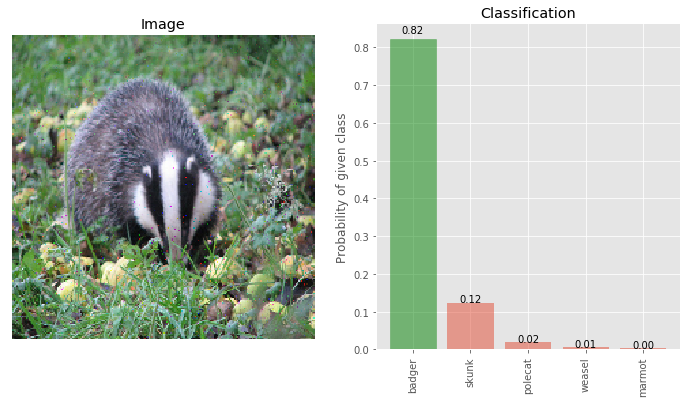

In [404]:
img_deflected_rcam = pixel_deflection_with_map(img_adversary, rcam_prob, deflections=1500, window=10)
_ = classify_images([img_deflected_rcam], true_label, visualize=True)

As we can see, performance of Pixel Deflection with RCAM is significantly higher ($82\%$) than Pixel Deflection without RCAM ($52\%$).
Since PD with RCAM skips deflections when the randomly selected pixel lies in the hot regions (as show by RCAM above), it needs, on average, more deflections than standard PD.

## Distribution of Pixel Deflection with RCAM

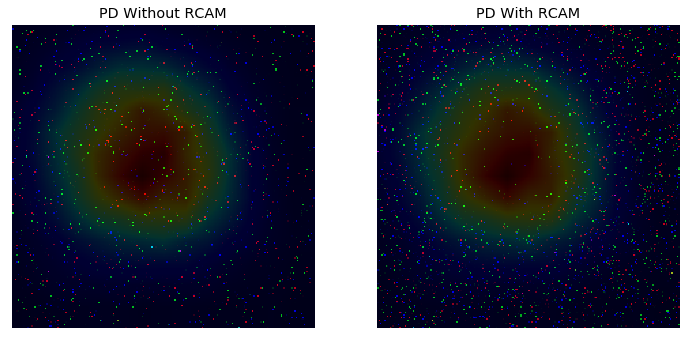

In [418]:
f, ax = plt.subplots(1,2, figsize=(12, 6))

diff1 = img_adversary - img_deflected_more
ax[0].imshow(diff1.astype('uint8'))
ax[0].imshow(rcam_prob, cmap='jet', alpha=0.2)
ax[0].set_title('PD Without RCAM')

diff2 = img_adversary - img_deflected_rcam
ax[1].imshow(diff2.astype('uint8'))
ax[1].imshow(rcam_prob, cmap='jet', alpha=0.2)
ax[1].set_title('PD With RCAM')

for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])


We can see that in the image which uses PD without RCAM number of pixels deflected in the HOT zone (_red color_) is much lower compared to the image that uses PD without RCAM.

## Wavelet Denoising after PD with RCAM

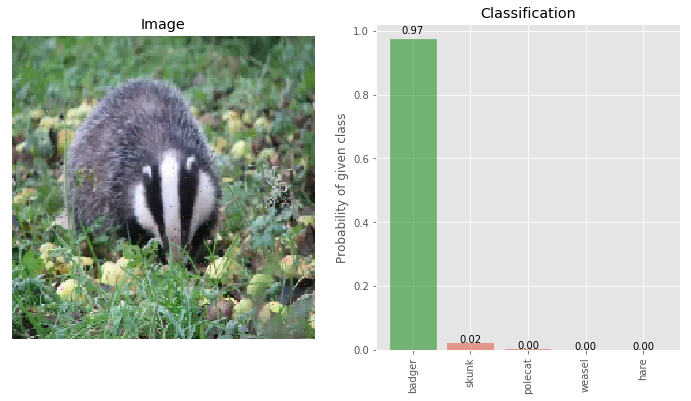

In [420]:
img_deflected_rcam_denoised = denoiser(img_deflected_rcam)
_ = classify_images([img_deflected_rcam_denoised], true_label, visualize=True)

Now the confidence on the true class being **badger** is $97\%$ and on the adversarial class is $2\%$. This is our best result.

## Results


| Class         | Clean         | Adversary  | PD       | PD + WD  | PD + RCAM| PD + RCAM + WD |
| ------------- |:-------------:| -----     :| -----   :| -----   :| -----   :| -----         :|
| True class - Badger | $100$ | $15$ | $75$ | $92$ | $82$ | $97$|
| Adversary  - Skunk  | $0.0$ | **$59$** | $16$ | $07$ | $12$ | $02$|

<center> (numbers denote confidence in each class) </center>

## Notes

For this image, it seems a window of 20 might give better results, but for experiments, I wanted to keep the same window as reported in our paper.
I have omitted the discussion of soft shrinkage for wavelet transform, which we found works much better than hard shrinkage.
There is also a benefit of about 1.6% of doing YCbCr transformation from RGB before doing wavelet transform.

Strictly, this is a black-box defense as the attack model does not know the defense strategy. Randomness of the strategy makes it harder to implement
a viable approximation without relying on a specific pattern of pixels. Our work is most similar to [this](https://arxiv.org/pdf/1711.00117.pdf) and [this](https://arxiv.org/abs/1711.01991).


## TL;DR

Select a random pixel in the image and replace it with another pixel from the local neighborhood.
This process changes local pixel arrangement but not global statistics and thus efficiently counteracts the adversarial changes and does not impact clean images.
This can be improved by selecting more pixels from regions outside of objects and by doing wavelet denoising.  


For errors and corrections please contact aprakash@brandeis.edu